In [1]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [2]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [3]:
#!mkdir ../yaml/august-10-2022
#!mkdir ../output/august-10-2022

In [5]:
# simulation parameters
time_limit = 500
time_step = 5
transcript_lens = [300, 300]
cellular_transcript_copy_number = 50
transgene_transcript_copy_numbers = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 300, 500]
ribosome_copy_number = 100
total_trna = 100
ribosome_binding_rates = [10000000.0, 10000000.0]
trna_charging_rate = 100.0
transcript_names = ["cellularProtein", "GFP"]
trna_props = (0.6, 0.4)
codon_comps_1 = (0.6, 0.4)
codon_comps_2 = [(0.6, 0.4), (0.5, 0.5), (0.4, 0.6), (0.3, 0.7), (0.2, 0.8), (0.1, 0.9)]

date = "august-10-2022"

In [6]:
for comp in codon_comps_2:
    serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                   codon_comps=[codon_comps_1, comp],
                                                   trna_proportion=trna_props,
                                                   transcript_names=transcript_names,
                                                   time_limit=time_limit,
                                                   time_step=time_step)
    serializer.serialize(f"../yaml/{date}")

In [7]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for transgene_copy in transgene_transcript_copy_numbers:
            for seed in range(1, 4):
                cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {transgene_copy} " + \
                  f"{ribosome_copy_number} {total_trna} {ribosome_binding_rates[0]} {ribosome_binding_rates[1]} {trna_charging_rate} {trna_charging_rate} ../output/{date}"
                stream.write(cmd)
                stream.write("\n")

In [8]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = pd.read_csv(f"{path}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    if tmp.empty:
        times = df_master["time"].to_list()
        dedup_times = []
        [dedup_times.append(x) for x in times if x not in dedup_times]
        next_best_time = take_closest(dedup_times, time)
        tmp = df_master.loc[df_master['time'] == next_best_time].groupby(["species"])["protein"].mean().reset_index()
    #tmp["codon_comp"] = perc_good
    return tmp

In [9]:
df_master = None

for codon_comp in codon_comps_2:
    df_tmp = None
    for transgene_copy in transgene_transcript_copy_numbers:
        path = f"../output/{date}/two_codon_multi_transcript_0.6_0.4_{codon_comp[0]}_{codon_comp[1]}_0.6_0.4" + \
               f"_{cellular_transcript_copy_number}_{transgene_copy}_{ribosome_copy_number}_{total_trna}" + \
               f"_{ribosome_binding_rates[0]}_{ribosome_binding_rates[1]}_{trna_charging_rate}_{trna_charging_rate}"
        tmp = get_average_protein(path, 0.5, 500, 3)
        tmp["transgene_copy"] = transgene_copy
        tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
        if df_tmp is not None:
            df_tmp = df_tmp.append(tmp, ignore_index=True)
        else:
            df_tmp = tmp
    df_tmp["codon_comp"] = codon_comp[0]
    if df_master is not None:
        df_master = df_master.append(df_tmp, ignore_index=True)
    else:
        df_master = df_tmp

df_master

,species,protein,transgene_copy,codon_comp
0,ATA_charged,26.333333,0,0.6
1,ATA_uncharged,13.666667,0,0.6
2,TTT_charged,42.000000,0,0.6
3,TTT_uncharged,18.000000,0,0.6
4,__cellularProtein_rbs,47.666667,0,0.6
...,...,...,...,...
793,TTT_uncharged,2.666667,500,0.1
794,__GFP_rbs,498.333333,500,0.1
795,__cellularProtein_rbs,50.000000,500,0.1
796,free ribosome,0.000000,500,0.1


In [10]:
pivot = df_master.pivot(index = ["codon_comp", "transgene_copy"], columns = "species", values = "protein").reset_index()
pivot["GFP"] = pivot["GFP"].fillna(0)
#pivot["cellularProtein_transformed"] = pivot["cellularProtein"] / pivot["cellularProtein"].max()
pivot["cellularProtein_transformed"] = pivot["cellularProtein"].groupby(pivot.codon_comp).transform(lambda x: x/x.max())
pivot["GFP_transformed"] = pivot["GFP"] / (pivot["GFP"] + pivot["cellularProtein"])
pivot["Percent_opt"] = (pivot["codon_comp"] / 0.6 * 100).round().astype("int")
pivot["exp_cellularProtein"] = np.exp(pivot["cellularProtein_transformed"])
pivot

species,codon_comp,transgene_copy,ATA_charged,ATA_uncharged,GFP,TTT_charged,TTT_uncharged,__GFP_rbs,__cellularProtein_rbs,cellularProtein,free ribosome,cellularProtein_transformed,GFP_transformed,Percent_opt,exp_cellularProtein
0,0.1,0,26.333333,13.666667,0.000000,42.000000,18.000000,NaN,47.666667,5458.000000,0.333333,1.000000,0.000000,17,2.718282
1,0.1,10,27.000000,13.000000,226.666667,41.000000,19.000000,10.000000,48.000000,5182.666667,0.000000,0.949554,0.041903,17,2.584557
2,0.1,20,26.000000,14.000000,720.333333,45.666667,14.333333,20.000000,49.666667,4546.333333,0.000000,0.832967,0.136772,17,2.300133
3,0.1,30,21.666667,18.333333,1328.333333,44.333333,15.666667,29.666667,48.666667,3698.333333,0.000000,0.677599,0.264257,17,1.969143
4,0.1,40,22.333333,17.666667,1827.666667,45.000000,15.000000,39.000000,49.000000,2944.333333,0.000000,0.539453,0.382998,17,1.715068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.6,100,27.333333,12.666667,4377.666667,37.666667,22.333333,97.666667,49.666667,1108.000000,0.000000,0.203005,0.798019,100,1.225078
86,0.6,150,27.333333,12.666667,4927.333333,39.666667,20.333333,148.000000,49.666667,558.333333,0.333333,0.102296,0.898220,100,1.107712
87,0.6,200,23.666667,16.333333,5144.000000,37.666667,22.333333,199.333333,49.666667,341.666667,0.000000,0.062599,0.937716,100,1.064600
88,0.6,300,23.666667,16.333333,5332.666667,40.333333,19.666667,297.666667,50.000000,156.333333,0.000000,0.028643,0.971519,100,1.029057


In [11]:
rcParams['figure.figsize'] = [8, 6]

Text(0, 0.5, 'Absolute cellular protein')

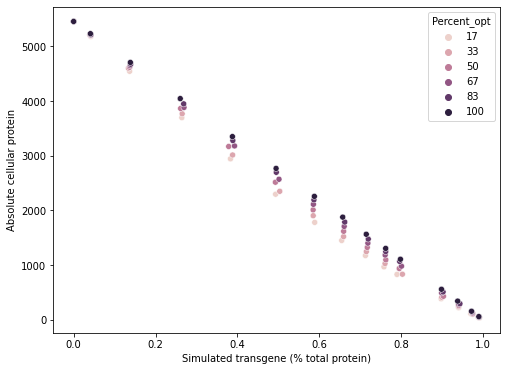

In [12]:
sns.scatterplot(data = pivot, x = "GFP_transformed", y = "cellularProtein", hue = "Percent_opt")
plt.xlabel("Simulated transgene (% total protein)")
plt.ylabel("Absolute cellular protein")

Text(0, 0.5, 'Charged rare tRNA')

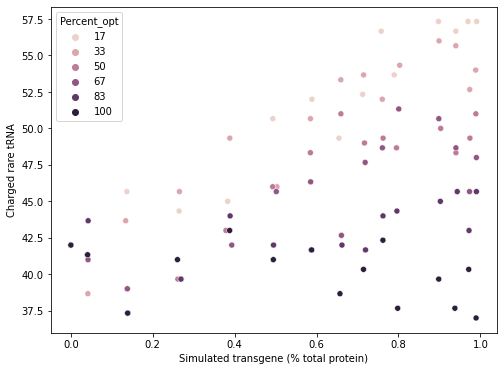

In [14]:
sns.scatterplot(data = pivot, x = "GFP_transformed", y = "TTT_charged", hue = "Percent_opt")
plt.xlabel("Simulated transgene (% total protein)")
plt.ylabel("Charged rare tRNA")

Text(0, 0.5, 'Charged rare tRNA')

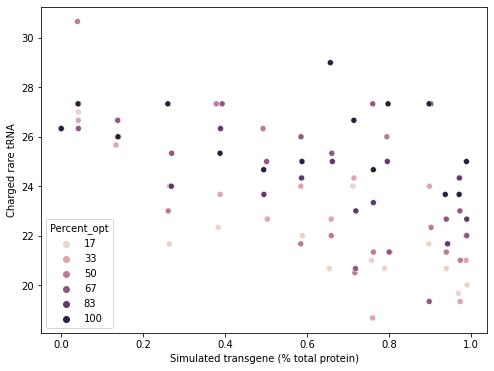

In [15]:
sns.scatterplot(data = pivot, x = "GFP_transformed", y = "ATA_charged", hue = "Percent_opt")
plt.xlabel("Simulated transgene (% total protein)")
plt.ylabel("Charged rare tRNA")

Text(0, 0.5, 'Charged rare tRNA')

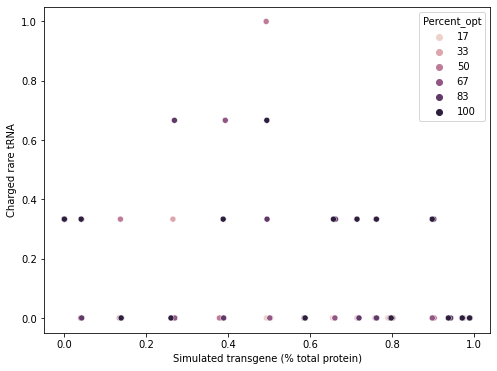

In [16]:
sns.scatterplot(data = pivot, x = "GFP_transformed", y = "free ribosome", hue = "Percent_opt")
plt.xlabel("Simulated transgene (% total protein)")
plt.ylabel("Charged rare tRNA")